# Modeling

## Setup Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import joblib

pd.set_option("display.max_rows", None)     # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 2000)        # Prevent line wrapping
pd.set_option("display.max_colwidth", None) # Don't truncate cell conte

In [2]:
data = pd.read_pickle('C:/Code/Git Repositories/Football/Football/3_Data_Preparation/rawdata_clean.pkl')

In [3]:

df = data.select_dtypes(include=['int64', 'float64'])
df = df.dropna()
sorted_df = df.sort_values(by=['season', 'week'])
X = sorted_df.drop(columns=['margin', 'away_score', 'home_score'])
y = sorted_df['margin']

split_idx = int(len(X) * 0.8)
tss_X_train, tss_X_test = X.iloc[:split_idx], X.iloc[split_idx:]
tss_y_train, tss_y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, random_state=369, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=.25, random_state=369, shuffle=False)



## Model Selection

#### Lasso Regression is continuously the best performer

In [4]:
elastic_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('ElasticNet', ElasticNet())])
ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('Ridge', Ridge())])
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('Lasso', Lasso())])
xgb = XGBRegressor()
rand_forest = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

elastic_cv = cross_val_score(elastic_pipe, X_train, y_train, cv=tscv, scoring='r2')
ridge_cv = cross_val_score(ridge_pipe, X_train, y_train, cv=tscv, scoring='r2')
lasso_cv = cross_val_score(lasso_pipe, X_train, y_train, cv=tscv, scoring='r2')
xgb_cv = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring='r2')
rand_forest_cv = cross_val_score(rand_forest, X_train, y_train, cv=tscv, scoring='r2')

print(f'elastic_cv score average: {elastic_cv.mean() * 100: .2f}. Standard deviation is {elastic_cv.std() * 100: .2f}')
print(f'ridge_cv score average: {ridge_cv.mean() * 100: .2f}. Standard deviation is {ridge_cv.std() * 100: .2f}')
print(f'lasso_cv score average: {lasso_cv.mean() * 100: .2f}. Standard deviation is {lasso_cv.std() * 100: .2f}')
print(f'xgb_cv score average: {xgb_cv.mean() * 100: .2f}. Standard deviation is {xgb_cv.std() * 100: .2f}')
print(f'rand_forest_cv score average: {rand_forest_cv.mean() * 100: .2f}. Standard deviation is {rand_forest_cv.std() * 100: .2f}')

elastic_cv score average:  74.16. Standard deviation is  1.00
ridge_cv score average:  73.09. Standard deviation is  8.21
lasso_cv score average:  75.81. Standard deviation is  1.29
xgb_cv score average:  72.92. Standard deviation is  3.56
rand_forest_cv score average:  72.56. Standard deviation is  2.97


## Model Tuning

#### ~5.5% increase from initial training

In [5]:
lasso_param_grid = {
    'Lasso__alpha': [0.01, 0.1, 0.3, 0.5, 0.7, 1],
    'Lasso__fit_intercept': [True, False],
    'Lasso__max_iter': [1000, 3000, 10000]
}

search = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, scoring='r2').fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}')
print(f'Best score: {search.best_score_ * 100: .2f}')

Best parameters: {'Lasso__alpha': 0.1, 'Lasso__fit_intercept': True, 'Lasso__max_iter': 1000}
Best score:  80.07


In [6]:
params = search.best_params_
clean_params = {k.replace('Lasso__', ''): v for k, v in params.items()}
tuned_lasso = Lasso(**clean_params).fit(X_train, y_train)

print(f'Tuned Lasso score: {tuned_lasso.score(X_train, y_train) * 100: .2f}')


Tuned Lasso score:  81.24


## Model Validation & Testing

#### Model generalizes very well

### Validation

In [7]:
predictions = tuned_lasso.predict(X_val)
mae = mean_absolute_error(y_val, predictions)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
score = r2_score(y_val, predictions)

print(f'mae is {mae: .2f}')
print(f'rmse is {rmse: .2f}')
print(f'r2 score is {score * 100: .2f}')

mae is  4.99
rmse is  6.29
r2 score is  80.31


### Test

In [8]:
predictions = tuned_lasso.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
score = r2_score(y_test, predictions)

print(f'mae is {mae: .2f}')
print(f'rmse is {rmse: .2f}')
print(f'r2 score is {score * 100: .2f}')

mae is  4.99
rmse is  6.43
r2 score is  79.54


## Residual Analysis

In [9]:
predictions = tuned_lasso.predict(X_test)
residuals = y_test - predictions

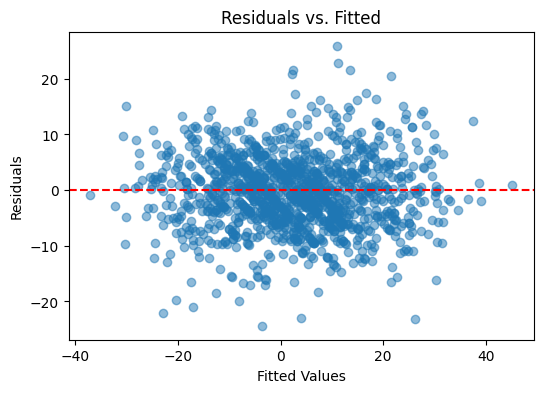

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(predictions, residuals, alpha=.5)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Residuals vs. Fitted')
plt.show()

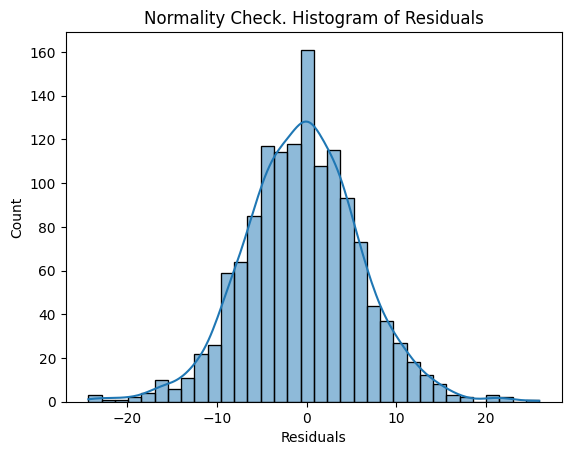

In [11]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Normality Check. Histogram of Residuals')
plt.show()

In [12]:
dw = sm.stats.durbin_watson(residuals)

print(f'Durbin-Watson score: {dw: .2f}')

Durbin-Watson score:  1.96


#### Edge Case Evaluation

In [15]:
top_10_thresh = sorted_df['margin'].quantile(0.90)
bottom_10_thresh = sorted_df['margin'].quantile(0.10)

top_10_df = sorted_df[sorted_df['margin'] >= top_10_thresh]
bottom_10_df = sorted_df[sorted_df['margin'] <= bottom_10_thresh]

features_df = sorted_df.drop(columns=['margin', 'home_score', 'away_score'])
features = features_df.columns

top_10_preds = tuned_lasso.predict(top_10_df[features])
bottom_10_preds = tuned_lasso.predict(bottom_10_df[features])

print('Top 10%:')
print('Average Margin:', f"{top_10_df['margin'].mean():.2f}")
print('RMSE:', np.sqrt(mean_squared_error(top_10_df['margin'], top_10_preds)))
print('MAE:', mean_absolute_error(top_10_df['margin'], top_10_preds))
print('R2:', f"{r2_score(top_10_df['margin'], top_10_preds) * 100:.2f}")

print('\nBottom 10%:')
print('Average Margin:', f"{bottom_10_df['margin'].mean():.2f}")
print('RMSE:', np.sqrt(mean_squared_error(bottom_10_df['margin'], bottom_10_preds)))
print('MAE:', mean_absolute_error(bottom_10_df['margin'], bottom_10_preds))
print('R2:', f"{r2_score(bottom_10_df['margin'], bottom_10_preds) * 100:.2f}")

Top 10%:
Average Margin: 28.02
RMSE: 8.90136040652565
MAE: 7.007829147824517
R2: -95.38

Bottom 10%:
Average Margin: -22.91
RMSE: 8.249468437213418
MAE: 6.635713699781489
R2: -84.67


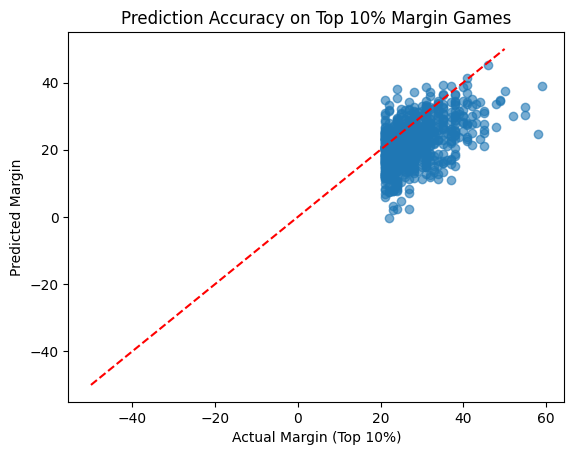

In [16]:
plt.scatter(top_10_df['margin'], top_10_preds, alpha=0.6)
plt.plot([-50, 50], [-50, 50], color='red', linestyle='--')
plt.xlabel('Actual Margin (Top 10%)')
plt.ylabel('Predicted Margin')
plt.title('Prediction Accuracy on Top 10% Margin Games')
plt.show()

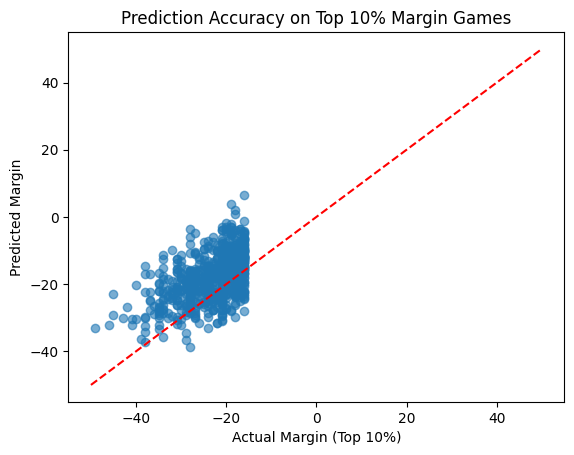

In [17]:
plt.scatter(bottom_10_df['margin'], bottom_10_preds, alpha=0.6)
plt.plot([-50, 50], [-50, 50], color='red', linestyle='--')
plt.xlabel('Actual Margin (Top 10%)')
plt.ylabel('Predicted Margin')
plt.title('Prediction Accuracy on Top 10% Margin Games')
plt.show()

While testing on the top and bottom 10 percent of our data we find that our model generalize very poorly, quite often worse than using the mean variance as a prediction. To address this we will later model on just our edge cases, to hopefully create a new model that is built just for predicting the edge cases.

In [18]:
window_size = 816  # adjust to your dataset size
test_size = 272
errors = {}

for start in range(0, len(sorted_df) - window_size - test_size):
    train = sorted_df.iloc[start : start + window_size]
    test = sorted_df.iloc[start + window_size : start + window_size + test_size]
    
    X_train = train[features]
    y_train = train['margin']
    X_test = test[features]
    y_test = test['margin']
    
    model = Lasso(**clean_params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    errors[start] = {'mae' : mae, 'rmse' : rmse, 'r2' : r2}
    
mae_mean = np.mean([metrics['mae'] for metrics in errors.values()])
rmse_mean = np.mean([metrics['rmse'] for metrics in errors.values()])
r2_mean = np.mean([metrics['r2'] for metrics in errors.values()]) 

print(f"Past three seasons Mean MAE: {mae_mean:.2f}")
print(f"Past three seasons Mean RMSE: {rmse_mean:.2f}")
print(f"Past three seasons Mean R2: {r2_mean * 100 :.2f}%")


Past three seasons Mean MAE: 5.39
Past three seasons Mean RMSE: 6.88
Past three seasons Mean R2: 77.60%


In [19]:
window_size = 6300  # adjust to your dataset size
test_size = 272
errors = {}

for start in range(0, len(sorted_df) - window_size - test_size):
    train = sorted_df.iloc[start : start + window_size]
    test = sorted_df.iloc[start + window_size : start + window_size + test_size]
    
    X_train = train[features]
    y_train = train['margin']
    X_test = test[features]
    y_test = test['margin']
    
    model = Lasso(**clean_params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    errors[start] = {'mae' : mae, 'rmse' : rmse, 'r2' : r2}
    
mae_mean = np.mean([metrics['mae'] for metrics in errors.values()])
rmse_mean = np.mean([metrics['rmse'] for metrics in errors.values()])
r2_mean = np.mean([metrics['r2'] for metrics in errors.values()])

print(f"All game data Mean MAE: {mae_mean:.2f}")
print(f"All game data Mean RMSE: {rmse_mean:.2f}")
print(f"All game data Mean R2: {r2_mean * 100 :.2f}%")

All game data Mean MAE: 4.82
All game data Mean RMSE: 6.21
All game data Mean R2: 81.07%


## Model Packaging

In [20]:
final_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('Lasso', Lasso(**clean_params))])
final_pipeline.fit(X, y)

,steps,"[('scaler', ...), ('Lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True


In [21]:
filename = "C:/Code/Git Repositories/Football/Football/4_5_Modeling_and_Evaluation/lasso_pipeline.pkl"
joblib.dump(final_pipeline, filename=filename)

['C:/Code/Git Repositories/Football/Football/4_5_Modeling_and_Evaluation/lasso_pipeline.pkl']